In [2]:
import numpy as np
import pickle


In [16]:
path = 'velocity_fields/alpha_0.8_2D/'

St = 0.1
R = 2
gravity = True
Fr = 0.5

x_grid = np.load(path + 'x.npy')
r_grid = np.load(path + 'y.npy')
Ux = np.load(path + 'Ux.npy')
Ur = np.load(path + 'Uy.npy')
dUxdx = np.load(path + 'dUxdx.npy')
dUxdr = np.load(path + 'dUxdy.npy')
dUrdx = np.load(path + 'dUydx.npy')
dUrdr = np.load(path + 'dUydy.npy')
geometry = np.load(path + 'geometry.npy', allow_pickle=True)
x_core, y_core, y_core_lower, x_ring, y_ring = geometry.T

# load interpolation functions
with open(path + 'interp_functions_v14.pkl', 'rb') as f:
    interp_Ux, interp_Ur, interp_dUxdx, interp_dUxdr, interp_dUrdx, interp_dUrdr = pickle.load(f)

In [25]:
def active_tracer_traj(t,Z):
        xp, yp, zp, dxpdt, dypdt, dzpdt = Z

        r_planar = np.sqrt(yp**2 + zp**2)
        theta = np.arctan2(zp, yp)   # check if this is correct

        Uxp = interp_Ux(xp, r_planar)[0][0]
        Urp = interp_Ur(xp, r_planar)[0][0]
        Uyp = Urp * yp / r_planar
        Uzp = Urp * zp / r_planar

        dUxdx_p = interp_dUxdx(xp, r_planar)[0][0]
        dUxdr_p = interp_dUxdr(xp, r_planar)[0][0]
        dUrdx_p = interp_dUrdx(xp, r_planar)[0][0]
        dUrdr_p = interp_dUrdr(xp, r_planar)[0][0]

        # apply chain rule for derivatives in the cartesian coordinate
        dUxdy_p = dUxdr_p / np.cos(theta) if np.cos(theta) != 0 else 0
        dUxdz_p = dUxdr_p / np.sin(theta) if np.sin(theta) != 0 else 0
        
        dUydx_p = dUrdx_p * np.cos(theta)
        dUydy_p = dUrdr_p + Urp / r_planar if r_planar != 0 else 0
        dUydz_p = dUrdr_p * np.cos(theta)/np.sin(theta) - Urp * np.cos(theta) *np.sin(theta) / r_planar if (np.sin(theta) != 0) and (r_planar != 0) else 0

        dUzdx_p = dUrdx_p * np.sin(theta)
        dUzdy_p = dUrdr_p * np.sin(theta)/np.cos(theta) - Urp * np.cos(theta) * np.sin(theta) / r_planar if (np.cos(theta) != 0) and (r_planar != 0) else 0
        dUzdz_p = dUrdr_p + Urp / r_planar if r_planar != 0 else 0

        dUxdt = 0
        dUydt = 0
        dUzdt = 0

        ddxpdtt = R*(Uxp - dxpdt)/St + (3*R/2) * (dUxdt + Uxp*dUxdx_p + Uyp*dUxdy_p + Uzp*dUxdz_p)
        ddypdtt = R*(Uyp - dypdt)/St + (3*R/2) * (dUydt + Uxp*dUydx_p + Uyp*dUydy_p + Uzp*dUydz_p)
        ddzpdtt = R*(Uzp - dzpdt)/St + (3*R/2) * (dUzdt + Uxp*dUzdx_p + Uyp*dUzdy_p + Uzp*dUzdz_p) - gravity * (1-3*R/2) / (Fr**2)

        return [dxpdt, dypdt, dzpdt, ddxpdtt, ddypdtt, ddzpdtt]
    

In [26]:
t_span = np.linspace(0, 100, 1000)
x0, y0, z0 = 0.2, 0.5, 0.9
vx0, vy0, vz0 = 0, 0, 0

from scipy.integrate import solve_ivp
import scipy as sp

sol = sp.integrate.solve_ivp(active_tracer_traj, [t_span[0], t_span[-1]], [x0, y0, z0, vx0, vy0, vz0], t_eval=t_span)

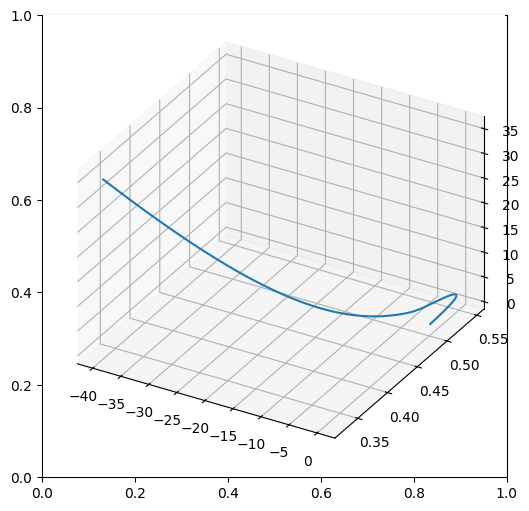

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = plt.axes(projection='3d', proj_type = 'ortho')
ax.plot(sol.y[0], sol.y[1], sol.y[2])

In [24]:
Z = [x0, y0, z0, vx0, vy0, vz0]
xp, yp, zp, dxpdt, dypdt, dzpdt = Z

r_planar = np.sqrt(yp**2 + zp**2)
theta = np.arctan2(zp, yp)   # check if this is correct

Uxp = interp_Ux(xp, r_planar)
Urp = interp_Ur(xp, r_planar)

print(Uxp[0][0])

0.16953131221465495
